# Merging Current & Future crop distributions

This notebook merges current and future distribution of a crop to be used for running the future scenarios.

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Conceptualization & Methodological review :** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Updates, Modifications:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Funding:** The World Bank (contract number: 7190531), [KTH](https://www.kth.se/en/itm/inst/energiteknik/forskning/desa/welcome-to-the-unit-of-energy-systems-analysis-kth-desa-1.197296)

In [65]:
# Importing necessary modules

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import os
import numpy as np
from earthpy import clip as cl
from shapely.geometry import Point, Polygon
from geopandas.tools import overlay
%matplotlib inline

In [66]:
# Define crop name
cropname = "Cassava"

## Importing, projecting and Plotting basemap

In [67]:
path_shp = r"N:\Agrodem\Downscaling\Input_Data\vectors\gadm36_MOZ_shp"
name_shp = "gadm36_MOZ_2.shp"
admin_gdf = gpd.read_file(path_shp + "\\" + name_shp)

In [68]:
# Reproject data in to Ordnance Survey GB coordinates
admin_gdf_prj = admin_gdf.to_crs({'init': 'epsg:32737'})

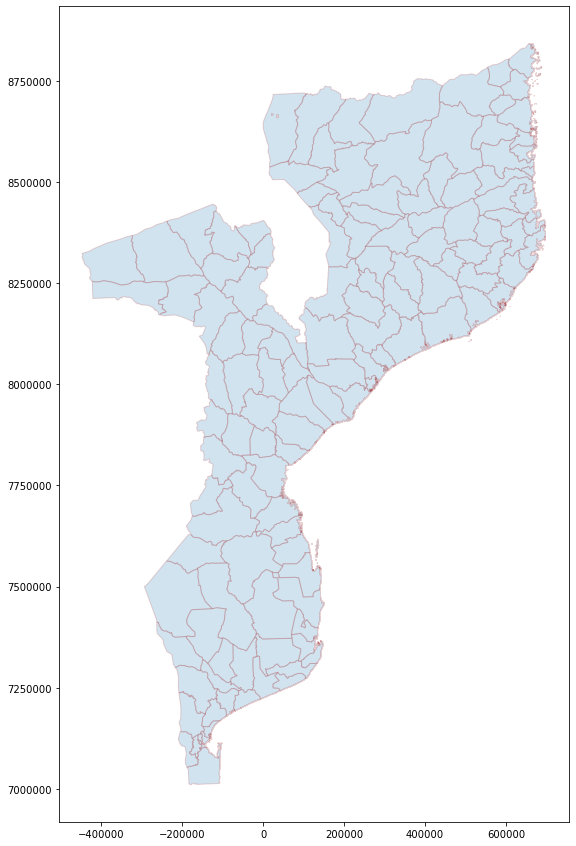

In [69]:
# Plot the data
fig, ax = plt.subplots(figsize=(15, 15))
admin_gdf_prj.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')

# Save plot as figure 
#plt.savefig('Maize_Harv_Area_2017.png', bbox_inches='tight')

## Importing current crop distribution - setting geodf, projecting and plotting

In [70]:
# Import data 
path = r"N:\Agrodem\Irrigation_model\Input_data\Downscaled_Crop"
name_of_file = "Cassava_Moz_1km_2017_downscaled.csv"

In [71]:
# Import csv as pandas dataframe
downscaled_crop = pd.read_csv(path + "\\" + name_of_file)

In [72]:
# Setting a geo dataframe - appointing geometry attribute
downscaled_crop['geometry'] = list(zip(downscaled_crop['lon'], downscaled_crop['lat']))
downscaled_crop['geometry'] = downscaled_crop['geometry'].apply(Point)
downscaled_crop = gpd.GeoDataFrame(downscaled_crop, geometry='geometry', crs={'init': 'epsg:4326'})

In [73]:
downscaled_crop_prj = downscaled_crop.to_crs({'init': 'epsg:32737'})

In [74]:
downscaled_crop_prj["Status"] = "Current"

In [75]:
downscaled_crop_prj.head(4)

,Pixel,State,lon,lat,Crop,Fraction,CassavaArea,geometry,Status
0,0,Massinga,34.43319,-22.28009,Cassava,4.200000e-07,0.000042,POINT (29183.669 7529046.250),Current
1,1,Massinga,34.44287,-22.28036,Cassava,4.000000e-08,0.000004,POINT (30184.048 7529046.532),Current
2,2,Massinga,34.90539,-22.36485,Cassava,1.600000e-07,0.000016,POINT (78183.723 7521046.544),Current
3,3,Massinga,34.91508,-22.36510,Cassava,0.000000e+00,0.000000,POINT (79183.927 7521046.013),Current


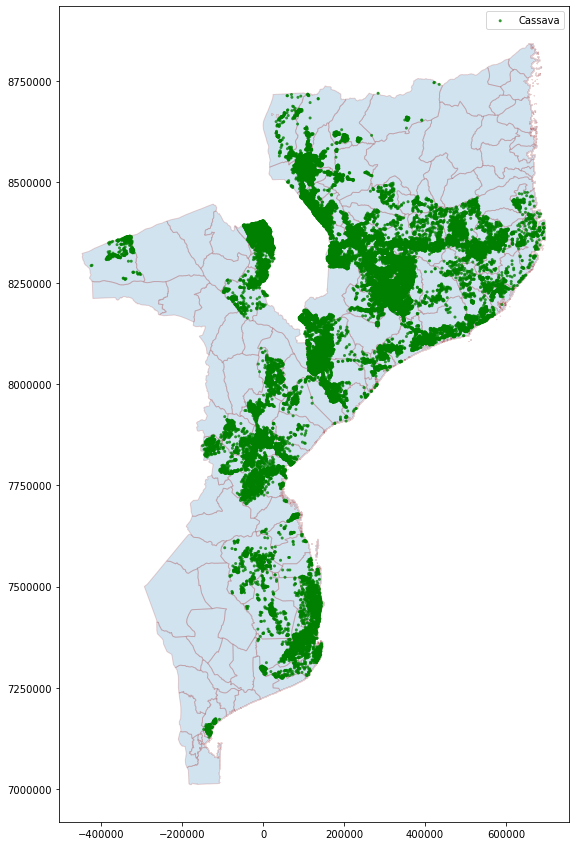

In [76]:
fig, ax = plt.subplots(figsize=(15, 15))
admin_gdf_prj.plot(ax=ax, edgecolor='brown', alpha=0.2)
downscaled_crop_prj.plot(ax=ax, color='green', edgecolor='none', figsize=(20, 20), alpha=0.8, label=cropname, marker='.')
#downscaled_maize_prj.plot(ax=ax, column='MaizeArea', figsize=(20, 20), alpha=0.8, label='Maize', legend = True)
ax.set_aspect('equal', 'box')
leg = ax.legend()
 
# Save plot as figure 
#plt.savefig('Maize_Harv_Area_2017.png', bbox_inches='tight')

## Importing future crop distribution - setting geodf, projecting and plotting

In [77]:
path_shp = r"N:\Agrodem\Future_Scenarios\maize_cassava_scenarios\maize_cassava_scenarios\vectorfiles"
name_shp = "cassava_SG.shp"
future_crop_gdf = gpd.read_file(path_shp + "\\" + name_shp)

In [78]:
## Reproject data in to Ordnance Survey GB coordinates
future_crop_gdf_prj = future_crop_gdf.to_crs({'init': 'epsg:32737'})

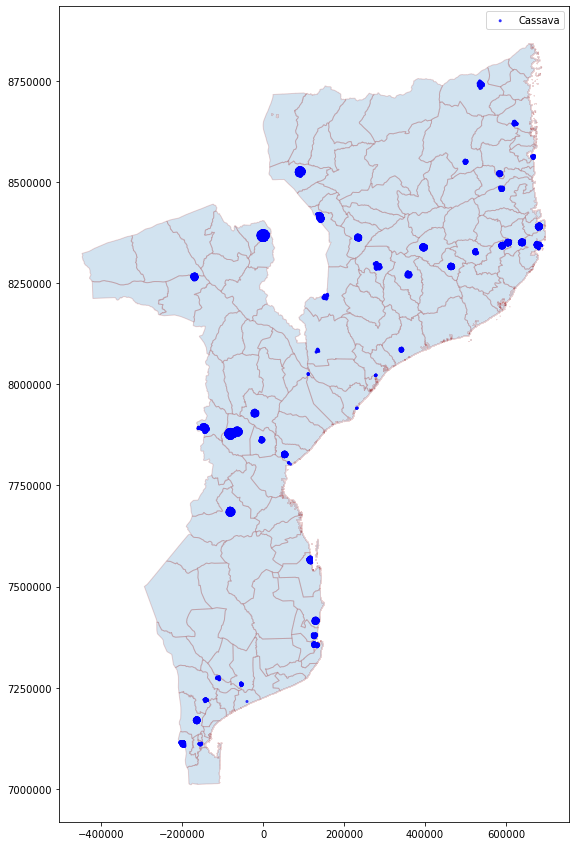

In [79]:
fig, ax = plt.subplots(figsize=(15, 15))
admin_gdf_prj.plot(ax=ax, edgecolor='brown', alpha=0.2)
future_crop_gdf_prj.plot(ax=ax, color='blue', edgecolor='none', figsize=(20, 20), alpha=0.8, label=cropname, marker='.')
#downscaled_maize_prj.plot(ax=ax, column='MaizeArea', figsize=(20, 20), alpha=0.8, label='Maize', legend = True)
ax.set_aspect('equal', 'box')
leg = ax.legend()
 
# Save plot as figure 
#plt.savefig('Maize_Harv_Area_2017.png', bbox_inches='tight')

#### Assigning state name for each location

In [80]:
#Spatial join -- assign state names per point in gpd
future_crop_gdf_prj_state = gpd.sjoin(future_crop_gdf_prj, admin_gdf_prj, op='intersects', how='left')

In [81]:
#future_crop_gdf_prj_state.columns

In [82]:
# Drop columns in this list
droping_cols = ['VALUE', 'index_right', 'GID_0', 'NAME_0',
                'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'VARNAME_2',
                'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2']

future_crop_gdf_prj_state.drop(droping_cols, axis=1, inplace=True)

In [83]:
# Fill in with remaining columns
cropnamearea = cropname + "Area"
# Note that for future locations we 
future_crop_gdf_prj_state.rename(columns={'NAME_2': 'State'}, inplace=True)
future_crop_gdf_prj_state["Pixel"] = future_crop_gdf_prj_state.index
future_crop_gdf_prj_state["Crop"] = cropname
future_crop_gdf_prj_state["Fraction"] = 1
future_crop_gdf_prj_state[cropnamearea] = 100
future_crop_gdf_prj_state["Status"] = "Future"

In [84]:
future_crop_gdf_prj_state.head(4)

,lon,lat,geometry,State,Pixel,Crop,Fraction,CassavaArea,Status
0,39.322436,-11.310195,POINT (535186.984 8749702.384),Mueda,0,Cassava,1,100,Future
1,39.327020,-11.319362,POINT (535686.048 8748688.186),Mueda,1,Cassava,1,100,Future
2,39.340770,-11.323946,POINT (537186.005 8748179.648),Mueda,2,Cassava,1,100,Future
3,39.304102,-11.337696,POINT (533183.023 8746663.609),Mueda,3,Cassava,1,100,Future


#### Re-ordering columns (optional)

In [85]:
#Function to change the order of columns in the dataframe 
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

In [86]:
# Allocate order in dataframe columns
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'Pixel', 1)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'State', 2)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'lon', 3)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'lat', 4)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'Crop', 5)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'Fraction', 6)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'CassavaArea', 7)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'geometry', 8)
future_crop_gdf_prj_state = change_column_order(future_crop_gdf_prj_state, 'Status', 9)

## Treat overlapping

This is a step to reassure there is no double counting of locations. Note that this proccess might take a while depending on capabilities of your working station. This is one way of doing so; there are other ways that might be faster and work better for you. 

#### Adding buffer to current crop locations

In [87]:
# Adding buffer to points
buffer_area = 500
downscaled_crop_prj_buffer = downscaled_crop_prj.copy()
downscaled_crop_prj_buffer['geometry'] = downscaled_crop_prj.buffer(buffer_area)

#### Dissolving all geometries to one polygon

In [88]:
# Note that we disolve by a column (here "Crop") that has the same attribute for all points
downscaled_crop_prj_buffer_diss = downscaled_crop_prj_buffer.dissolve(by='Crop')

#### Classify points inside/outside of dissolved polygon

In [89]:
# Find points inside
pointsinside = gpd.sjoin(future_crop_gdf_prj_state,downscaled_crop_prj_buffer_diss,how="inner")

In [90]:
# Find points outside
future_crop_gdf_prj_state_out = future_crop_gdf_prj_state[~future_crop_gdf_prj_state.index.isin(pointsinside.index)]

## Merging geodataframes to create future crop allocation

In [91]:
# Make a list of geodataframes to Concatenate
frames = [downscaled_crop_prj, future_crop_gdf_prj_state_out]

# Concatenate to a new geodataframe
future_crop_allocation = pd.concat(frames)

In [92]:
# Re-indexing allocation keys to avoid dublicates
future_crop_allocation = future_crop_allocation.assign(Pixel=np.arange(len(future_crop_allocation))).reset_index(drop=True)

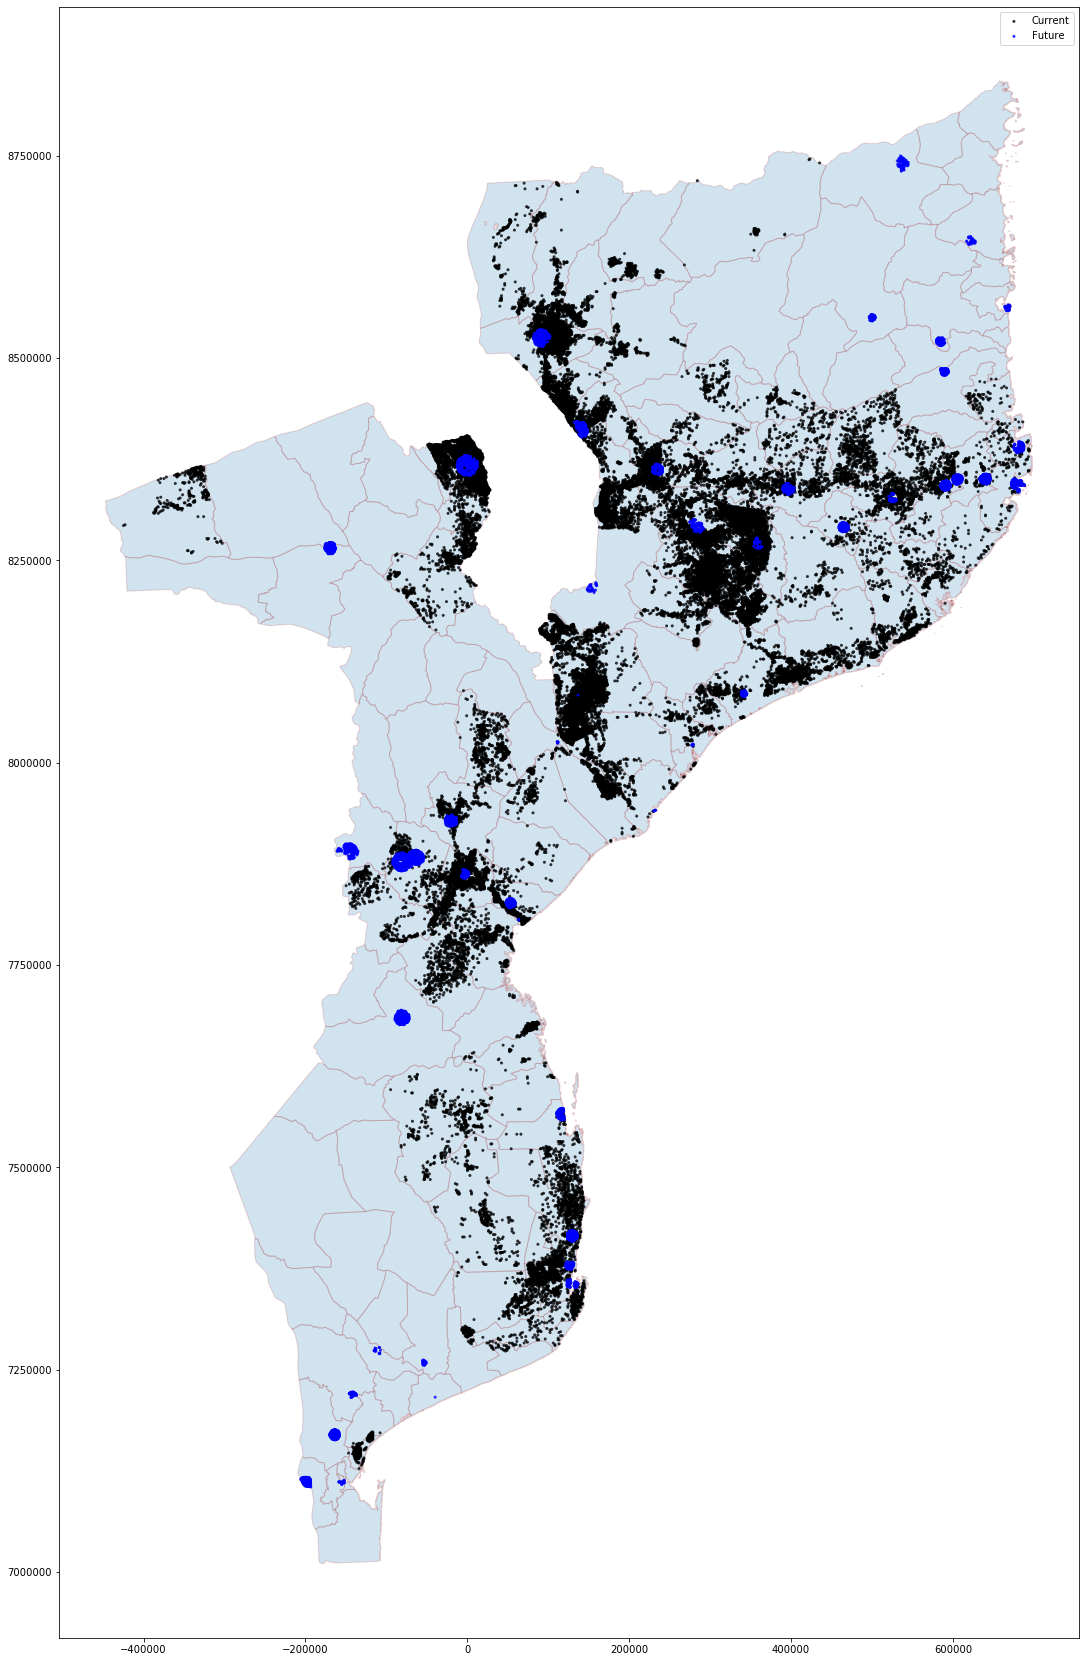

In [93]:
# Plot the data
fig, ax = plt.subplots(figsize=(30, 30))
admin_gdf_prj.plot(ax=ax, edgecolor='brown', alpha=0.2)
future_crop_allocation[future_crop_allocation["Status"] == "Current"].plot(ax=ax, figsize=(20, 20), alpha=0.8, color='black', edgecolor='none', marker='.', label='Current', legend = True)
future_crop_allocation[future_crop_allocation["Status"] == "Future"].plot(ax=ax, figsize=(20, 20), alpha=0.8, color='blue', edgecolor='none', marker='.', label='Future', legend = True)
ax.set_aspect('equal', 'box')
leg = ax.legend()

# Save plot as figure 
#plt.savefig('Maize_Harv_area_2030.png', bbox_inches='tight')

### Exports

In [94]:
# Define output path
shp_path = r"N:\Agrodem\Irrigation_model\Input_data\Future_crop_allocation\shapefiles"
csv_path = r"N:\Agrodem\Irrigation_model\Input_data\Future_crop_allocation"

outfilename = cropname + "_Harv_area_2030_SG"

#Future crop allocation
future_crop_allocation.to_file(os.path.join(shp_path,"{c}.shp".format(c=outfilename)))

#Future crop allocation
future_crop_allocation.to_csv(os.path.join(csv_path,"{c}.csv".format(c=outfilename)))

### Rasterization (testing)

In [95]:
#import rasterio
#from rasterio.features import rasterize
#from rasterio.transform import from_bounds

In [96]:
#shape = 1000, 1000
#transform = rasterio.transform.from_bounds(*downscaled_maize_prj['geometry'].total_bounds, *shape)
#rasterized_maize = rasterize(
#    [(shape, 1) for shape in downscaled_maize_prj['geometry']],
#    out_shape=shape,
#    transform=transform,
#    fill=0,
#    all_touched=True,
#    dtype=rasterio.uint8)
#
#with rasterio.open(
#    'rasterized-results.tif', 'w',
#    driver='GTiff',
#    dtype=rasterio.uint8,
#    count=1,
#    width=shape[0],
#    height=shape[1],
#    transform=transform
#) as dst:
#    dst.write(rasterized_maize, indexes=1)